In [1]:
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Input
from tensorflow.keras import layers
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from PIL import Image

# Experiment 1


Text(0.5, 1.0, 'Shape: (32, 32, 3)')

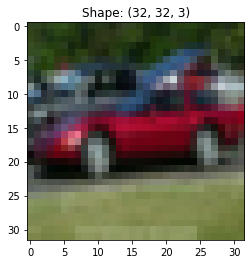

In [2]:
# load data and split it into Test, train and validation sets

(X_1, y_1), (X_2, y_2) = tf.keras.datasets.cifar10.load_data()
X = np.vstack((X_1, X_2))
y = np.vstack((y_1, y_2))
X_train, X, y_train, y = train_test_split(X, y, train_size=0.8, stratify=y)
X_test, X_valid, y_test, y_valid = train_test_split(X, y, test_size=0.5, stratify=y)

assert X_test.shape == X_valid.shape, 'X_test and X_valid have different shapes'
for i in range(10):
    assert np.count_nonzero(keras.utils.to_categorical(y_train)[:, i]) == 4800 , 'Sample is not stratified'
sample_shape = X_train[0].shape
plt.imshow(X_train[1])
plt.title(f'Shape: {sample_shape}')

In [3]:
# normalize the data
# it would be better to use keras.utils.normalize for this, but then it would be impossible to de-normalize the data

X_train = X_train/255
X_valid = X_valid/255
X_test = X_test/255

In [4]:
# build the model

model = Sequential()
model.add(Input(shape=sample_shape))
model.add(Conv2D(8, kernel_size = (3,3), padding='same',  activation='relu'))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Conv2D(12, kernel_size = (3,3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Conv2D(16, kernel_size = (3,3), padding='same', activation='relu'))
model.add(UpSampling2D(size=(2,2)))
model.add(Conv2D(12,kernel_size = (3,3), padding='same', activation='relu'))
model.add(UpSampling2D())
model.add(Conv2D(3,(3,3), padding='same', activation='relu'))


# compile the model
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss=keras.losses.MeanSquaredError(),
    metrics=[keras.metrics.MeanAbsoluteError(),
            keras.metrics.CosineSimilarity()])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 8)         224       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 8)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 12)        876       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 12)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 16)          1744      
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 16, 16, 16)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 12)        1

In [ ]:
# train the model
history = model.fit(X_train, X_train, validation_data=(X_valid, X_valid), epochs=10, verbose=1, use_multiprocessing=True)

In [ ]:
model.evaluate(X_test, X_test)


In [ ]:
predictions = model.predict(X_train, verbose=1)

In [ ]:
def plot_img_compare(model, data, img_nr):
    """Plot original image next to predicted image 

    Args:
        model (model accepting.predict() method): the model to predict
        data (np.array): the whole data stack
        img_nr (int): the index of to use for image plot.
    """
    assert type(img_nr) == int, 'wrong dtype for img_nr'
    predictions = model.predict(data)
    pred_img = predictions[img_nr]
    plt.subplot(221).imshow(data[img_nr])
    plt.subplot(221).set_title(f'original img: {data[img_nr].shape}')
    plt.subplot(222).imshow(pred_img)
    plt.subplot(222).set_title(f'predict img: {predictions[img_nr].shape}')
    plt.show()

plot_img_compare(model, X_test, 1)

In [ ]:
def save_model(model, path = 'models/CAE'):
    model.save(path)
def load_model(path = 'models/CAE'):
    return keras.models.load_model(path)
model = load_model()

## stuff

### learn seperate model for greyscale and model for combination of color and grayscale

In [8]:
# learn model for b-w version of the images

to_grayscale = lambda x: x[:,:,:,0]/3 + x[:,:,:,1]/3 + x[:,:,:,2]/3

X_train_bw = to_grayscale(X_train)
X_test_bw = to_grayscale(X_test)
X_valid_bw = to_grayscale(X_valid)

In [9]:
X_train_bw = X_train_bw[:,:,:,np.newaxis]
X_test_bw = X_test_bw[:,:,:,np.newaxis]
X_valid_bw = X_valid_bw[:,:,:,np.newaxis]


In [ ]:
def comp_rgb_bw(rgb_img, gray_img):
    plt.subplot(221).imshow(rgb_img)
    plt.subplot(221).set_title(f'original img: {rgb_img.shape}')
    plt.subplot(222).imshow(gray_img, cmap='gray')
    plt.subplot(222).set_title(f'predict img: {gray_img.shape}')
    plt.show()
comp_rgb_bw(X_train[0], X_train_bw[0])

In [ ]:
# build the model_bw

model_bw = Sequential()
model_bw.add(Input(shape=X_train_bw[0].shape))
model_bw.add(Conv2D(8, kernel_size = (3,3), padding='same',  activation='relu'))
model_bw.add(Conv2D(12, kernel_size = (3,3), padding='same',  activation='relu'))
model_bw.add(MaxPooling2D(pool_size = (2,2)))
model_bw.add(Conv2D(16, kernel_size = (3,3), padding='same', activation='relu'))
model_bw.add(MaxPooling2D(pool_size = (2,2)))
model_bw.add(Conv2D(32, kernel_size = (3,3), padding='same', activation='relu'))
model_bw.add(Conv2D(32, kernel_size = (3,3), padding='same', activation='relu'))
model_bw.add(UpSampling2D(size=(2,2)))
model_bw.add(Conv2D(16,kernel_size = (3,3), padding='same', activation='relu'))
model_bw.add(UpSampling2D())
model_bw.add(Conv2D(12,kernel_size = (3,3), padding='same', activation='relu'))
model_bw.add(UpSampling2D())
model_bw.add(Conv2D(6,kernel_size = (3,3), padding='same', activation='relu'))
model_bw.add(MaxPooling2D(pool_size = (2,2)))
model_bw.add(Conv2D(1,(3,3), padding='same', activation='relu'))


# compile the model_bw
model_bw.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss=keras.losses.MeanSquaredError(),
    metrics=[keras.metrics.MeanAbsoluteError(),
            keras.metrics.CosineSimilarity()])

model_bw.summary()

In [ ]:
history_bw = model_bw.fit(X_train_bw, X_train_bw, epochs=7, validation_data=(X_valid_bw, X_valid_bw), verbose=1, use_multiprocessing=True)

Epoch 1/2
1500/1500 [==============================] - 175s 116ms/step - loss: 0.0083 - mean_absolute_error: 0.0575 - cosine_similarity: 0.9980 - val_loss: 0.0038 - val_mean_absolute_error: 0.0434 - val_cosine_similarity: 0.9986
Epoch 2/2
1500/1500 [==============================] - 176s 117ms/step - loss: 0.0035 - mean_absolute_error: 0.0413 - cosine_similarity: 0.9977 - val_loss: 0.0034 - val_mean_absolute_error: 0.0414 - val_cosine_similarity: 0.9961


In [ ]:
model_bw.evaluate(X_test_bw, X_test_bw)

188/188 [==============================] - 5s 27ms/step - loss: 0.0034 - mean_absolute_error: 0.0416 - cosine_similarity: 0.9970


[0.003407752141356468, 0.041581299155950546, 0.996958315372467]

In [ ]:
predictions_bw = model_bw.predict(X_train_bw, verbose=1)

In [ ]:
predictions_bw.shape
X_train_comb = np.concatenate((predictions, predictions_bw),3)

In [ ]:
# build model_comb for combination of prediction model_comb

model_comb = Sequential()
model_comb.add(Input(shape=X_train_comb[0].shape))
model_comb.add(Conv2D(8, kernel_size = (3,3), padding='same',  activation='relu'))
model_comb.add(MaxPooling2D(pool_size = (2,2)))
model_comb.add(Conv2D(12, kernel_size = (3,3), padding='same', activation='relu'))
model_comb.add(MaxPooling2D(pool_size = (2,2)))
model_comb.add(Conv2D(16, kernel_size = (3,3), padding='same', activation='relu'))
model_comb.add(UpSampling2D(size=(2,2)))
model_comb.add(Conv2D(12,kernel_size = (3,3), padding='same', activation='relu'))
model_comb.add(UpSampling2D())
model_comb.add(Conv2D(3,(3,3), padding='same', activation='relu'))


# compile the model_comb
model_comb.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss=keras.losses.MeanSquaredError(),
    metrics=[keras.metrics.MeanAbsoluteError(),
            keras.metrics.CosineSimilarity()])

model_comb.summary()

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_102 (Conv2D)          (None, 32, 32, 8)         296       
_________________________________________________________________
max_pooling2d_40 (MaxPooling (None, 16, 16, 8)         0         
_________________________________________________________________
conv2d_103 (Conv2D)          (None, 16, 16, 12)        876       
_________________________________________________________________
max_pooling2d_41 (MaxPooling (None, 8, 8, 12)          0         
_________________________________________________________________
conv2d_104 (Conv2D)          (None, 8, 8, 16)          1744      
_________________________________________________________________
up_sampling2d_34 (UpSampling (None, 16, 16, 16)        0         
_________________________________________________________________
conv2d_105 (Conv2D)          (None, 16, 16, 12)      

In [ ]:
history_comb = model_comb.fit(X_train_comb, X_train, epochs=7, verbose=1, use_multiprocessing=True)

Epoch 1/7
1500/1500 [==============================] - 52s 34ms/step - loss: 0.0134 - mean_absolute_error: 0.0769 - cosine_similarity: 0.9834
Epoch 2/7
1500/1500 [==============================] - 51s 34ms/step - loss: 0.0062 - mean_absolute_error: 0.0568 - cosine_similarity: 0.9917
Epoch 3/7
1500/1500 [==============================] - 52s 35ms/step - loss: 0.0057 - mean_absolute_error: 0.0542 - cosine_similarity: 0.9921
Epoch 4/7
1500/1500 [==============================] - 52s 35ms/step - loss: 0.0054 - mean_absolute_error: 0.0526 - cosine_similarity: 0.9921
Epoch 5/7
1500/1500 [==============================] - 52s 34ms/step - loss: 0.0052 - mean_absolute_error: 0.0516 - cosine_similarity: 0.9921
Epoch 6/7
1500/1500 [==============================] - 49s 33ms/step - loss: 0.0051 - mean_absolute_error: 0.0508 - cosine_similarity: 0.9921
Epoch 7/7
1500/1500 [==============================] - 53s 35ms/step - loss: 0.0050 - mean_absolute_error: 0.0502 - cosine_similarity: 0.9920


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


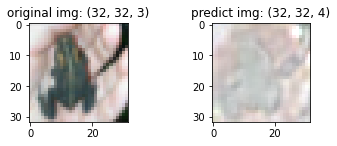

In [ ]:
predict_comb = model_comb.predict(X_train_comb)

def comp_comb_org(comb_img, org_img):
    plt.subplot(221).imshow(org_img)
    plt.subplot(221).set_title(f'original img: {org_img.shape}')
    plt.subplot(222).imshow(comb_img)
    plt.subplot(222).set_title(f'predict img: {comb_img.shape}')
    plt.show()


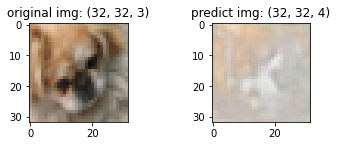

In [ ]:
comp_rgb_bw(X_train[1], X_train_comb[1])

In [ ]:
save_model(model_comb, 'models/model_pipe_comb')
save_model(model_bw, 'models/model_pipe_bw')

INFO:tensorflow:Assets written to: models/model_pipe_comb/assets
INFO:tensorflow:Assets written to: models/model_pipe_bw/assets


### try different model architectures

In [95]:
model_test = Sequential()
model_test.add(Input(shape=sample_shape))
model_test.add(Conv2D(128, kernel_size = (3,3), padding='same',  activation='relu'))
model_test.add(Conv2D(92, kernel_size = (3,3), padding='same',  activation='relu'))
model_test.add(MaxPooling2D(pool_size = (2,2)))
model_test.add(Conv2D(78, kernel_size = (3,3), padding='same', activation='relu'))
model_test.add(MaxPooling2D(pool_size = (2,2)))
model_test.add(Conv2D(64, kernel_size = (3,3), padding='same', activation='relu'))





model_test.add(UpSampling2D(size=(2,2)))
model_test.add(Conv2D(32,kernel_size = (3,3), padding='same', activation='relu'))
model_test.add(Conv2D(24,kernel_size = (3,3), padding='same', activation='relu'))
model_test.add(Conv2D(16,kernel_size = (3,3), padding='same', activation='relu'))

model_test.add(UpSampling2D())
model_test.add(Conv2D(8,kernel_size = (3,3), padding='same', activation='relu'))
model_test.add(Conv2D(3,(3,3), padding='same', activation='relu'))

model_test.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss=keras.losses.MeanSquaredError(),
    metrics=[keras.metrics.MeanAbsoluteError(),
            keras.metrics.CosineSimilarity()])
model_test.summary()


Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_154 (Conv2D)          (None, 32, 32, 128)       3584      
_________________________________________________________________
conv2d_155 (Conv2D)          (None, 32, 32, 92)        106076    
_________________________________________________________________
max_pooling2d_45 (MaxPooling (None, 16, 16, 92)        0         
_________________________________________________________________
conv2d_156 (Conv2D)          (None, 16, 16, 78)        64662     
_________________________________________________________________
max_pooling2d_46 (MaxPooling (None, 8, 8, 78)          0         
_________________________________________________________________
conv2d_157 (Conv2D)          (None, 8, 8, 64)          44992     
_________________________________________________________________
up_sampling2d_55 (UpSampling (None, 16, 16, 64)      

In [ ]:
model_test.fit(X_train, X_train, validation_data=(X_valid, X_valid), epochs=10, verbose=1)
predictions_test = model_test.predict(X_test)

In [6]:
  def img_compare(img_org, img_pred):
    
    plt.subplot(221).imshow(img_org)
    plt.subplot(221).set_title(f'original img: {img_org.shape}')
    plt.subplot(222).imshow(img_pred)
    plt.subplot(222).set_title(f'predict img: {img_pred.shape}')
    plt.show()
  #img_compare(X_test[45], predictions_test[45])

### try model_test for recolorization

In [24]:
model_test = Sequential()
# model_test.add(Input(shape=X_train_bw.shape))
model_test.add(Conv2D(16, kernel_size = (3,3), padding='same',  activation='relu', input_shape=(32,32,1)))
model_test.add(Conv2D(28, kernel_size = (3,3), padding='same',  activation='relu'))
model_test.add(MaxPooling2D(pool_size = (2,2)))
model_test.add(Conv2D(32, kernel_size = (3,3), padding='same', activation='relu'))
model_test.add(MaxPooling2D(pool_size = (2,2)))
model_test.add(Conv2D(64, kernel_size = (3,3), padding='same', activation='relu'))
model_test.add(Conv2D(32,kernel_size = (3,3), padding='same', activation='relu'))
model_test.add(UpSampling2D(size=(2,2)))
model_test.add(Conv2D(32,kernel_size = (3,3), padding='same', activation='relu'))
model_test.add(Conv2D(24,kernel_size = (3,3), padding='same', activation='relu'))
model_test.add(Conv2D(16,kernel_size = (3,3), padding='same', activation='relu'))

model_test.add(UpSampling2D())
model_test.add(Conv2D(12,kernel_size = (3,3), padding='same', activation='relu'))
model_test.add(UpSampling2D())
model_test.add(Conv2D(10,kernel_size = (3,3), padding='same', activation='relu'))
model_test.add(MaxPooling2D())

model_test.add(Conv2D(8,kernel_size = (3,3), padding='same', activation='relu'))
model_test.add(Conv2D(8,kernel_size = (3,3), padding='same', activation='relu'))
model_test.add(Conv2D(3,(3,3), padding='same', activation='sigmoid'))


model_test.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-2),
    loss=keras.losses.MeanSquaredError(),
    metrics=[keras.metrics.MeanAbsoluteError(),
            keras.metrics.CosineSimilarity(),
             keras.metrics.Accuracy()])
model_test.summary()


Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_99 (Conv2D)           (None, 32, 32, 16)        160       
_________________________________________________________________
conv2d_100 (Conv2D)          (None, 32, 32, 28)        4060      
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 16, 16, 28)        0         
_________________________________________________________________
conv2d_101 (Conv2D)          (None, 16, 16, 32)        8096      
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 8, 8, 32)          0         
_________________________________________________________________
conv2d_102 (Conv2D)          (None, 8, 8, 64)          18496     
_________________________________________________________________
conv2d_103 (Conv2D)          (None, 8, 8, 32)         

In [25]:
print(X_train_bw.shape, X_train.shape)

model_test.fit(X_train_bw, X_train, validation_data=(X_valid_bw, X_valid), epochs=10, verbose=1)
predictions_test_recol = model_test.predict(X_test_bw, verbose=1)

(48000, 32, 32, 1) (48000, 32, 32, 3)
Epoch 1/10
1500/1500 [==============================] - 35s 23ms/step - loss: 0.0135 - mean_absolute_error: 0.0845 - cosine_similarity: 0.9794 - accuracy: 1.8989e-07 - val_loss: 0.0094 - val_mean_absolute_error: 0.0708 - val_cosine_similarity: 0.9799 - val_accuracy: 3.2552e-07
Epoch 2/10
1500/1500 [==============================] - 33s 22ms/step - loss: 0.0094 - mean_absolute_error: 0.0714 - cosine_similarity: 0.9800 - accuracy: 2.4414e-07 - val_loss: 0.0087 - val_mean_absolute_error: 0.0682 - val_cosine_similarity: 0.9806 - val_accuracy: 1.0851e-07
Epoch 3/10
1500/1500 [==============================] - 33s 22ms/step - loss: 0.0089 - mean_absolute_error: 0.0694 - cosine_similarity: 0.9801 - accuracy: 1.8989e-07 - val_loss: 0.0086 - val_mean_absolute_error: 0.0681 - val_cosine_similarity: 0.9799 - val_accuracy: 4.3403e-07
Epoch 4/10
1500/1500 [==============================] - 33s 22ms/step - loss: 0.0086 - mean_absolute_error: 0.0680 - cosine_simi

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  


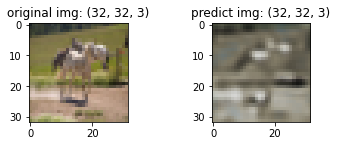

In [26]:
img_compare(X_test[5], predictions_test_recol[5])

In [142]:
small_model_color = Sequential()
small_model_color.add(Conv2D(8, (3,3), padding='same', activation='relu', input_shape=(32,32,1)))
small_model_color.add(MaxPooling2D())
small_model_color.add(Conv2D(16, kernel_size = (3,3), padding='same',  activation='relu'))
small_model_color.add(MaxPooling2D())
small_model_color.add(Conv2D(32, kernel_size = (3,3), padding='same',  activation='relu'))
small_model_color.add(UpSampling2D())
small_model_color.add(Conv2D(16, kernel_size = (3,3), padding='same',  activation='relu'))
small_model_color.add(UpSampling2D())
small_model_color.add(Conv2D(8, (3,3), padding='same', activation='relu'))
small_model_color.add(Conv2D(1, (3,3), padding='same', activation='relu'))


small_model_color.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss=keras.losses.MeanSquaredError(),
    metrics=[keras.metrics.MeanAbsoluteError(),
            keras.metrics.CosineSimilarity(),
             keras.metrics.Accuracy()])
small_model_color.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_40 (Conv2D)           (None, 32, 32, 8)         80        
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 16, 16, 8)         0         
_________________________________________________________________
conv2d_41 (Conv2D)           (None, 16, 16, 16)        1168      
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 8, 8, 16)          0         
_________________________________________________________________
conv2d_42 (Conv2D)           (None, 8, 8, 32)          4640      
_________________________________________________________________
up_sampling2d_10 (UpSampling (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_43 (Conv2D)           (None, 16, 16, 16)      

In [146]:
def pred_3_col_chan():
  predictions = np.zeros(X_test.shape)

  for i in range(3):


    current_X = X_train[:,:,:,i]
    current_X = current_X.reshape(48000, 32, 32, 1)
    small_model_color.compile(
      optimizer=keras.optimizers.Adam(learning_rate=1e-3),
      loss=keras.losses.MeanSquaredError(),
      metrics=[keras.metrics.MeanAbsoluteError(),
              keras.metrics.CosineSimilarity(),
              keras.metrics.Accuracy()])
    small_model_color.summary()
    small_model_color.fit(current_X, current_X, epochs=10, verbose=1)


    curr_predictions = small_model_color.predict(X_test, verbose=1)
    predictions[:,:,:,i] = curr_predictions
  return predictions
single_color_predict = pred_3_col_chan()

(48000, 32, 32, 1)
Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_40 (Conv2D)           (None, 32, 32, 8)         80        
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 16, 16, 8)         0         
_________________________________________________________________
conv2d_41 (Conv2D)           (None, 16, 16, 16)        1168      
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 8, 8, 16)          0         
_________________________________________________________________
conv2d_42 (Conv2D)           (None, 8, 8, 32)          4640      
_________________________________________________________________
up_sampling2d_10 (UpSampling (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_43 (Conv2D)           (None

ValueError: ignored

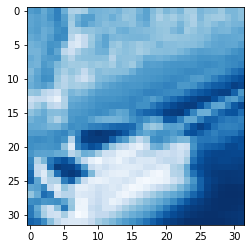

In [134]:
plt.imshow(X_train[1,:,:,0], cmap='Blues')

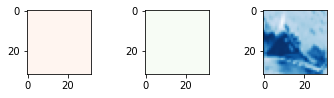

In [129]:
test = np.zeros((32,32,))
#test[:,:,1] = X_train[0,:,:,1]
# test = test.reshape((32,32,1))


for i, col in zip(range(3), ['Reds', 'Greens', 'Blues']):
  img = np.stack((np.zeros((32,32)), np.zeros((32,32)), X_train[0,:,:,i]),2).reshape(32,32,3)
  curr_img = img[:,:,i]
  plt.subplot(int('33' + f'{i+1}')).imshow(curr_img, cmap= col)

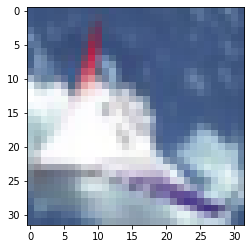

In [127]:
plt.imshow( X_train[0])

In [54]:
plt.show()

In [130]:
X_train[0,:,:,0].shape

(32, 32)

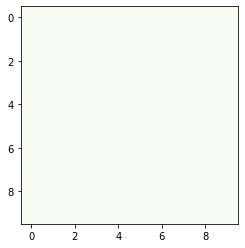

In [138]:
plt.imshow(np.zeros((10,10)), cmap='Greens')